> reference: 

[PatchTST：长时间序列预测神器](https://blog.csdn.net/hellozhxy/article/details/133676770)

[Transformer时间序列：PatchTST引领时间序列预测](https://blog.csdn.net/weixin_42010722/article/details/131430367)

pip neuralforecast装不上，去ray-2.32.0-cp311-cp311-win_amd64.whl官网[下载](https://pypi.org/project/ray/#files)
然后再pip neuralforecast

In [18]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
from neuralforecast.core import NeuralForecast 
from neuralforecast.models import NHITS, NBEATS, PatchTST
 
from neuralforecast.losses.pytorch import MAE
from neuralforecast.losses.numpy import mae, mse
 
from datasetsforecast.long_horizon import LongHorizon

In [4]:
Y_df, X_df, S_df = LongHorizon.load(
              directory="./data", 
              group="Exchange")

100%|██████████| 314M/314M [00:41<00:00, 7.64MiB/s] 
INFO:datasetsforecast.utils:Successfully downloaded datasets.zip, 314116557, bytes.
INFO:datasetsforecast.utils:Decompressing zip file...
INFO:datasetsforecast.utils:Successfully decompressed data\longhorizon\datasets\datasets.zip


In [5]:
Y_df['ds'] = pd.to_datetime(Y_df['ds'] )
 
Y_df.head()

,unique_id,ds,y
0,0,1990-01-01,0.606785
1,0,1990-01-02,0.570900
2,0,1990-01-03,0.618423
3,0,1990-01-04,0.611634
4,0,1990-01-05,0.600966


In [6]:
Y_df['unique_id'].value_counts()

unique_id
0     7588
1     7588
2     7588
3     7588
4     7588
5     7588
6     7588
OT    7588
Name: count, dtype: int64

In [7]:
val_size = 760
test_size = 1517
n_time = 7588

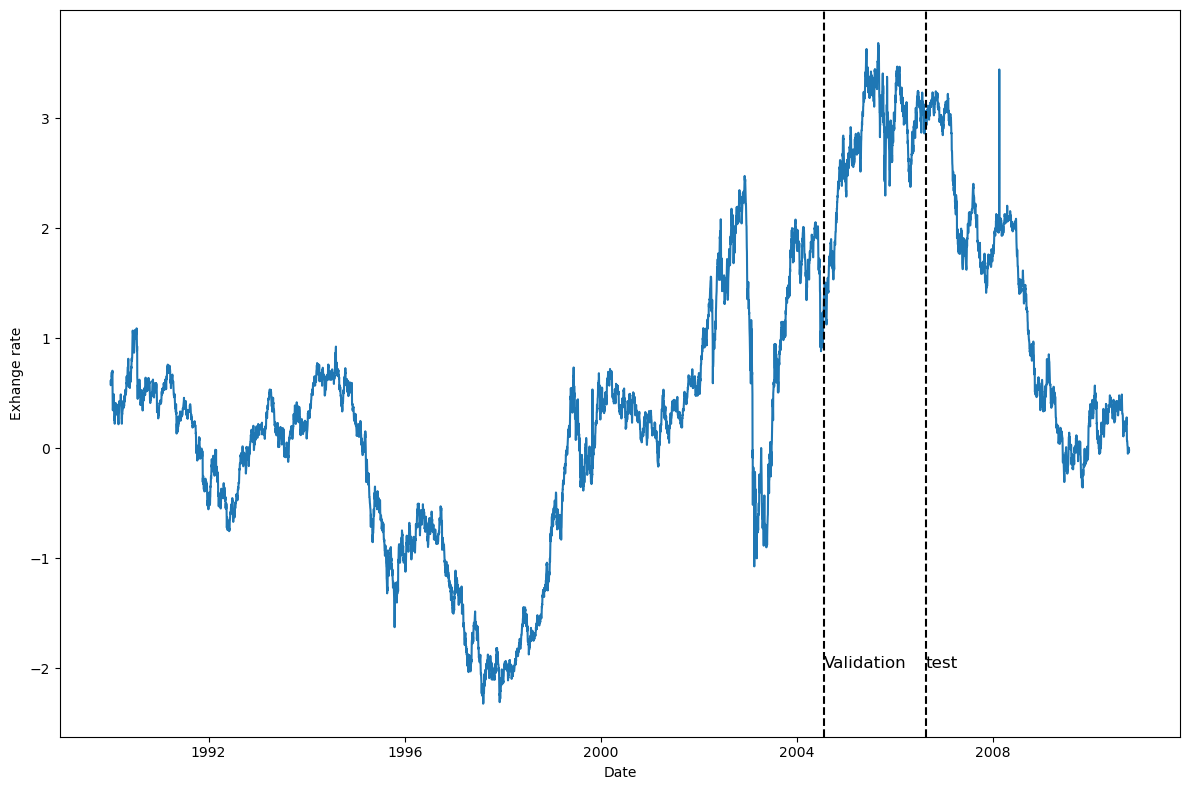

In [12]:
u_id = '0'
 
x_plot = pd.to_datetime(Y_df[Y_df.unique_id==u_id].ds)
y_plot = Y_df[Y_df.unique_id==u_id].y.values
 
x_plot
 
x_val = x_plot[n_time - val_size - test_size]
x_test = x_plot[n_time - test_size]
 
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x_plot, y_plot)
ax.set_xlabel('Date')
ax.set_ylabel('Exhange rate')
ax.axvline(x_val, color='black', linestyle='--')
ax.axvline(x_test, color='black', linestyle='--')
 
plt.text(x_val, -2, 'Validation', fontsize=12)
plt.text(x_test,-2, 'test', fontsize=12)
 
plt.tight_layout()

In [16]:
horizon = 96
 
models = [NHITS(h=horizon,
               input_size=2*horizon,
               max_steps=50),
         NBEATS(h=horizon,
               input_size=2*horizon,
               max_steps=50),
         PatchTST(h=horizon,
                 input_size=2*horizon,
                 max_steps=50)]

Global seed set to 1
Global seed set to 1
Global seed set to 1


In [19]:
nf = NeuralForecast(models=models, freq='D')


In [20]:
preds_df = nf.cross_validation(df=Y_df, 
          val_size=val_size, 
          test_size=test_size, 
          n_windows=None)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [21]:
preds_df

,unique_id,ds,cutoff,NHITS,NBEATS,PatchTST,y
0,0,2006-08-16,2006-08-15,2.888877,2.917713,2.909362,2.948076
1,0,2006-08-17,2006-08-15,2.919759,2.900134,2.933036,3.049320
2,0,2006-08-18,2006-08-15,2.926640,2.927250,2.928148,3.064168
3,0,2006-08-19,2006-08-15,2.898472,2.893037,2.957339,3.005783
4,0,2006-08-20,2006-08-15,2.894890,2.927988,2.944296,3.010031
...,...,...,...,...,...,...,...
1092091,OT,2010-10-06,2010-07-06,1.323648,1.250250,1.339357,0.902640
1092092,OT,2010-10-07,2010-07-06,1.313924,1.245751,1.318769,0.953585
1092093,OT,2010-10-08,2010-07-06,1.317165,1.248068,1.353463,0.956124
1092094,OT,2010-10-09,2010-07-06,1.312796,1.244779,1.358280,0.921979


In [22]:
y_true = preds_df['y'].values
y_pred_nhits = preds_df['NHITS'].values
y_pred_nbeats = preds_df['NBEATS'].values
y_pred_patchtst = preds_df['PatchTST'].values
 
n_series = len(Y_df['unique_id'].unique())
 
y_true = y_true.reshape(n_series, -1, horizon)
y_pred_nhits = y_pred_nhits.reshape(n_series, -1, horizon)
y_pred_nbeats = y_pred_nbeats.reshape(n_series, -1, horizon)
y_pred_patchtst = y_pred_patchtst.reshape(n_series, -1, horizon)

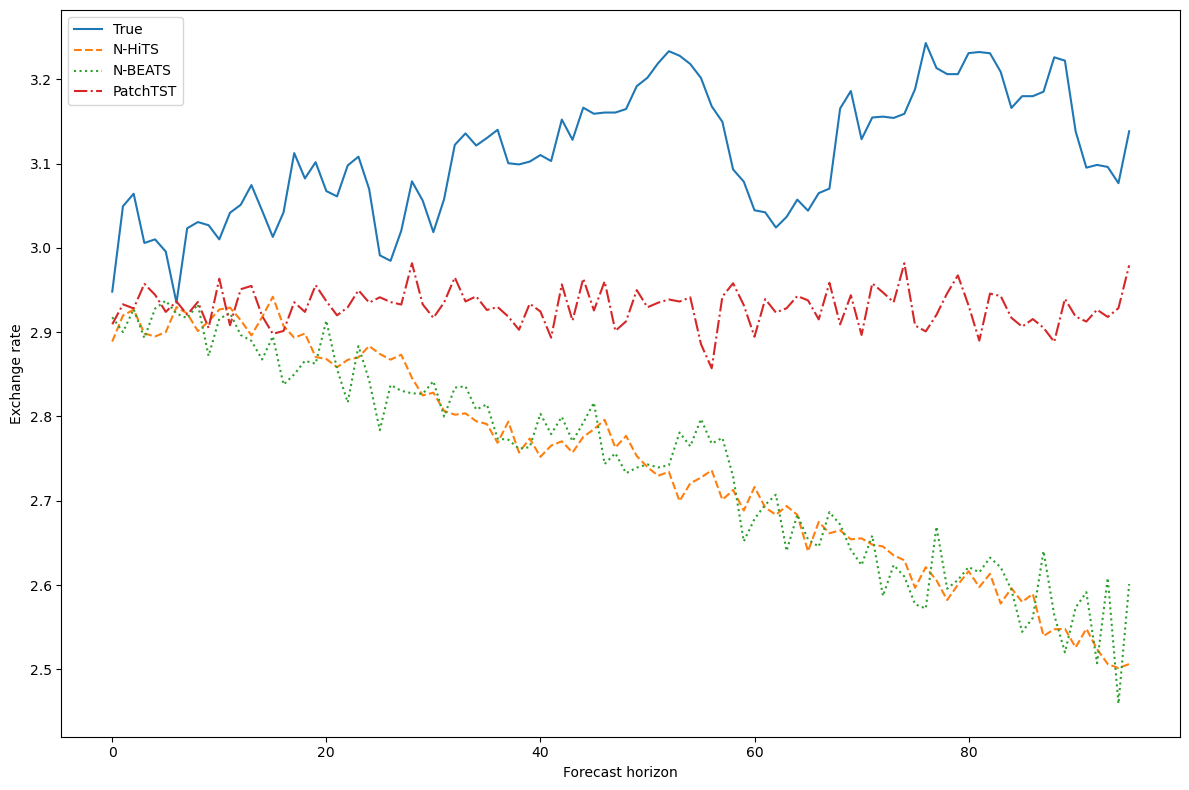

In [24]:
fig, ax = plt.subplots(figsize=(12,8))
 
ax.plot(y_true[0, 0, :], label='True')
ax.plot(y_pred_nhits[0, 0, :], label='N-HiTS', ls='--')
ax.plot(y_pred_nbeats[0, 0, :], label='N-BEATS', ls=':')
ax.plot(y_pred_patchtst[0, 0, :], label='PatchTST', ls='-.')
ax.set_ylabel('Exchange rate')
ax.set_xlabel('Forecast horizon')
ax.legend(loc='best')
 
plt.tight_layout()

In [25]:
data = {'N-HiTS':[mae(y_pred_nhits, y_true), mse(y_pred_nhits, y_true)],
    'N-BEATS':[mae(y_pred_nbeats, y_true), mse(y_pred_nbeats, y_true)],
    'PatchTST':[mae(y_pred_patchtst, y_true), mse(y_pred_patchtst, y_true)] }
 
metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse'] 
 
metrics_df.style.highlight_min(color='lightgreen', axis=1)

,N-HiTS,N-BEATS,PatchTST
mae,0.204381,0.202711,0.198054
mse,0.082925,0.081183,0.081633
